# Bayesian Pitcher Skill Estimation

> Hierarchical Bayesian model for MLB pitcher performance analysis  

---

Model estimates each pitcher's true underlying FIP as a latent variable, with uncertainty quantified via a full posterior distribution.

**Key concepts demonstrated:**
- Hierarchical (partial pooling) Bayesian model
- NUTS sampler via NumPyro + JAX JIT compilation
- Bayesian shrinkage visualization
- Posterior predictive checks with ArviZ


## 1. Setup & Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats


import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az


## 2. Load & Explore Pitcher Data

Pitcher season level data for 2025 pulled from FanGraphs

**Target variable:** FIP (Fielding Independent Pitching), pitching metric that aims to remove defense from the equation, isolating strikeouts, walks, and home runs. Lower is better.


In [2]:
fangraphs_2025_pitching = pd.read_csv("fangraphs_pitching_2025.csv")


In [3]:
fangraphs_2025_pitching.head()

,Name,Team,G,GS,IP,K/9,BB/9,HR/9,BABIP,LOB%,ERA,FIP,xFIP,WAR
0,Logan Webb,SFG,34,34,207.0,9.74,2.00,0.61,0.346,74.3,3.22,2.60,2.78,5.5
1,Garrett Crochet,BOS,32,32,205.1,11.18,2.02,1.05,0.290,84.3,2.59,2.89,2.64,5.8
2,Cristopher Sánchez,PHI,32,32,202.0,9.45,1.96,0.53,0.298,79.8,2.50,2.55,2.77,6.4
3,Tarik Skubal,DET,31,31,195.1,11.10,1.52,0.83,0.273,80.6,2.21,2.45,2.66,6.6
4,Carlos Rodón,NYY,33,33,195.1,9.35,3.36,1.01,0.228,76.4,3.09,3.78,3.89,3.2


In [4]:
fangraphs_2025_pitching.isna().sum()

Name     0
Team     0
G        0
GS       0
IP       0
K/9      0
BB/9     0
HR/9     0
BABIP    0
LOB%     0
ERA      0
FIP      0
xFIP     0
WAR      0
dtype: int64

In [5]:
fangraphs_2025_pitching.sort_values("ERA", ascending=False)

,Name,Team,G,GS,IP,K/9,BB/9,HR/9,BABIP,LOB%,ERA,FIP,xFIP,WAR
291,Bradley Blalock,COL,14,12,58.2,4.14,3.53,2.61,0.332,57.3,9.36,7.31,5.67,-1.0
521,Zach Brzykcy,WSN,26,0,23.0,9.39,4.70,2.35,0.333,56.5,9.00,6.27,5.29,-0.3
444,Carson Palmquist,COL,9,7,34.1,7.08,6.55,2.62,0.318,64.4,8.91,7.80,6.57,-0.6
532,Austin Cox,ATL,13,1,21.1,9.28,2.95,3.80,0.328,65.6,8.86,7.54,4.01,-0.6
494,Connor Gillispie,MIA,6,6,26.0,7.96,3.81,2.08,0.317,50.6,8.65,5.75,5.06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,Edwin Díaz,NYM,62,0,66.1,13.30,2.85,0.54,0.260,86.1,1.63,2.28,2.49,2.0
392,Cole Winn,TEX,33,0,41.2,7.56,3.67,0.65,0.194,90.5,1.51,3.90,4.37,0.2
472,Erik Miller,SFG,36,0,30.0,6.60,6.00,0.00,0.289,89.4,1.50,3.97,5.15,0.1
482,Andrew Saalfrank,ARI,28,0,29.0,5.90,3.10,0.31,0.217,87.0,1.24,3.31,4.61,0.5


In [6]:
#Rename columns
cols = {"Name": "name", "Team": "team", "IP": "ip", "ERA": "era", "FIP": "fip", "xFIP": "xfip", "K/9": "k9", "BB/9": "bb9", "HR/9": "hr9", "BABIP": "babip", "LOB%": "lob_pct", "G": "games", "GS": "starts",}

fangraphs_2025_pitching = fangraphs_2025_pitching[list(cols.keys())].rename(columns=cols)

### Analysis will focus just on starters, small sample issue is asymmetric, 20 IP for a reliever is likely a lot more informative than 20 IP for a starter and requires less care

<Axes: xlabel='start_proportion', ylabel='Count'>

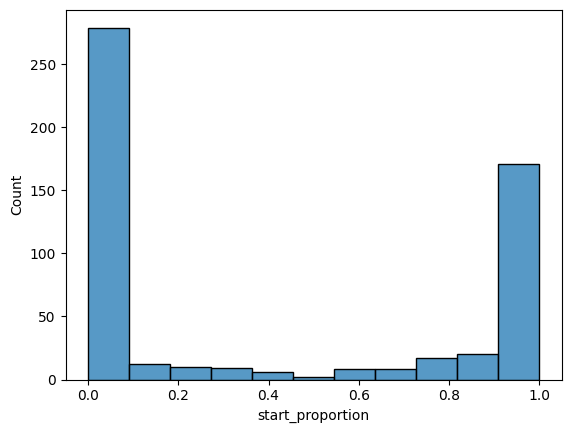

In [7]:
fangraphs_2025_pitching["start_proportion"] = fangraphs_2025_pitching["starts"] / fangraphs_2025_pitching["games"]
sns.histplot(fangraphs_2025_pitching["start_proportion"])

In [8]:
fangraphs_2025_pitching = fangraphs_2025_pitching[fangraphs_2025_pitching["start_proportion"] >= 0.6]

In [9]:
print(f"Working dataset: {len(fangraphs_2025_pitching)} pitchers")

Working dataset: 222 pitchers


In [10]:
fangraphs_2025_pitching["fip"].describe()

count    222.000000
mean       4.336126
std        1.010488
min        1.900000
25%        3.730000
50%        4.240000
75%        4.915000
max        8.290000
Name: fip, dtype: float64

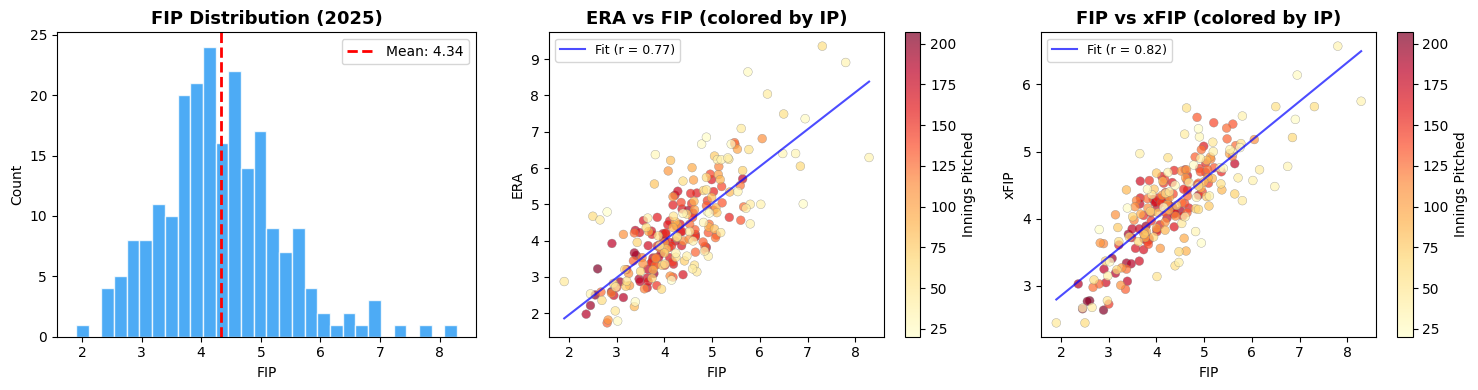

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# FIP distribution histogram
axes[0].hist(fangraphs_2025_pitching["fip"], bins=30, color="#2196F3", alpha=0.8, edgecolor="white")
axes[0].axvline(fangraphs_2025_pitching["fip"].mean(), color="red", lw=2, linestyle="--", label=f"Mean: {fangraphs_2025_pitching['fip'].mean():.2f}")
axes[0].set_title("FIP Distribution (2025)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("FIP"); axes[0].set_ylabel("Count"); axes[0].legend()

# ERA vs FIP scatter
r_era_fip, _ = stats.pearsonr(fangraphs_2025_pitching["fip"], fangraphs_2025_pitching["era"])
sc = axes[1].scatter(fangraphs_2025_pitching["fip"], fangraphs_2025_pitching["era"], c=fangraphs_2025_pitching["ip"], cmap="YlOrRd", alpha=0.7, s=40, edgecolors="gray", linewidth=0.3)
m, b = np.polyfit(fangraphs_2025_pitching["fip"], fangraphs_2025_pitching["era"], 1)
x_line = np.linspace(fangraphs_2025_pitching["fip"].min(), fangraphs_2025_pitching["fip"].max(), 100)
axes[1].plot(x_line, m * x_line + b, "blue", lw=1.5, alpha=0.7, label=f"Fit (r = {r_era_fip:.2f})")
axes[1].set_title("ERA vs FIP (colored by IP)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("FIP"); axes[1].set_ylabel("ERA")
axes[1].legend(fontsize=9)
plt.colorbar(sc, ax=axes[1], label="Innings Pitched")

# FIP vs xFIP scatter
r_fip_xfip, _ = stats.pearsonr(fangraphs_2025_pitching["fip"], fangraphs_2025_pitching["xfip"])
sc = axes[2].scatter(fangraphs_2025_pitching["fip"], fangraphs_2025_pitching["xfip"], c=fangraphs_2025_pitching["ip"], cmap="YlOrRd", alpha=0.7, s=40, edgecolors="gray", linewidth=0.3)
m, b = np.polyfit(fangraphs_2025_pitching["fip"], fangraphs_2025_pitching["xfip"], 1)
x_line = np.linspace(fangraphs_2025_pitching["fip"].min(), fangraphs_2025_pitching["fip"].max(), 100)
axes[2].plot(x_line, m * x_line + b, "blue", lw=1.5, alpha=0.7, label=f"Fit (r = {r_fip_xfip:.2f})")
axes[2].set_title("FIP vs xFIP (colored by IP)", fontsize=13, fontweight="bold")
axes[2].set_xlabel("FIP"); axes[2].set_ylabel("xFIP")
axes[2].legend(fontsize=9)
plt.colorbar(sc, ax=axes[2], label="Innings Pitched")

plt.tight_layout()
plt.show()

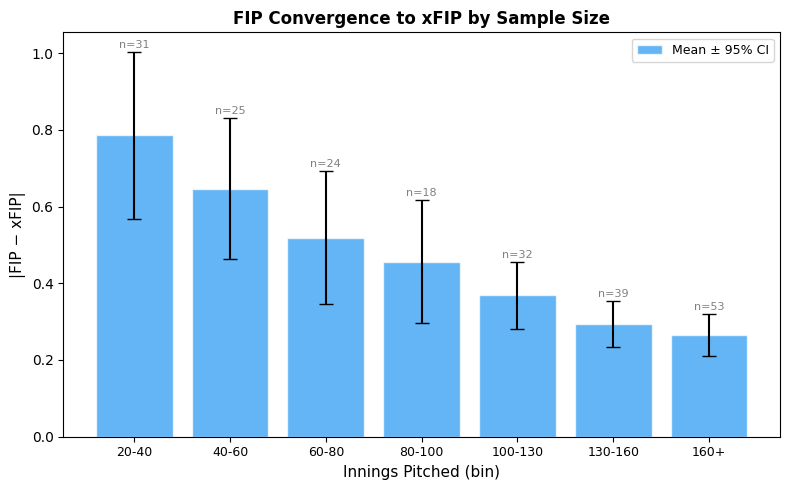

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

df = fangraphs_2025_pitching.copy()
df["gap"] = (df["fip"] - df["xfip"]).abs()

bins = [20, 40, 60, 80, 100, 130, 160, 210]
labels = ["20-40", "40-60", "60-80", "80-100", "100-130", "130-160", "160+"]
df["ip_bin"] = pd.cut(df["ip"], bins=bins, labels=labels)

gap_stats = df.groupby("ip_bin", observed=True)["gap"].agg(["mean", "std", "count"]).reset_index()
gap_stats["se"] = gap_stats["std"] / np.sqrt(gap_stats["count"])

ax.bar(range(len(gap_stats)), gap_stats["mean"], color="#2196F3", alpha=0.7,
       yerr=gap_stats["se"] * 1.96, capsize=5, error_kw={"elinewidth": 1.5},
       edgecolor="white", label="Mean ± 95% CI")

for i, row in gap_stats.iterrows():
    ax.text(i, row["mean"] + gap_stats["se"].iloc[i] * 1.96 + 0.01,
            f"n={int(row['count'])}", ha="center", fontsize=8, color="gray")

ax.set_xticks(range(len(gap_stats)))
ax.set_xticklabels(labels, fontsize=9)
ax.set_xlabel("Innings Pitched (bin)", fontsize=11)
ax.set_ylabel("|FIP − xFIP|", fontsize=11)
ax.set_title("FIP Convergence to xFIP by Sample Size",
             fontsize=12, fontweight="bold")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## 3. Hierarchical Bayesian Model

### Model specification

We model each pitcher's observed FIP as drawn from a normal distribution centered on their **true skill** $\theta_i$, using FIP as a proxy for skill. These true skills are drawn from a league-wide prior, which is the partial pooling that creates shrinkage.

$$\mu_{\text{league}}, \sigma_{\text{league}} \sim \text{HalfNormal priors}$$

$$\theta_i \sim \mathcal{N}(\mu_{\text{league}},\ \sigma_{\text{league}})$$

$$\sigma_{\text{obs},i} = \frac{\sigma_{\text{base}}}{\sqrt{IP_i / IP_{\text{ref}}}}$$

$$\text{FIP}_i \sim \mathcal{N}(\theta_i,\ \sigma_{\text{obs},i})$$

$\sigma_{\text{obs},i}$ shrinks with more innings. A pitcher with 200 IP has much tighter observation noise than one with 20 IP, so the model trusts their data more and shrinks less.


## Model Specification

We model each pitcher's observed FIP as drawn from a normal distribution centered on 
their latent true skill $\theta_i$, which is itself drawn from a league-wide distribution 
estimated from the data.

$$\mu_{\text{league}} \sim \mathcal{N}(4.0, 1.0)$$

We center the league mean prior at 4.0, consistent with historical MLB starter averages. 
The standard deviation of 1.0 is intentionally loose. We avoid setting this directly from the data to prevent double dipping.

$$\sigma_{\text{league}} \sim \text{HalfNormal}(0.8)$$

Controls how spread out true talent is across the league. HalfNormal constrains it to 
positive values since a standard deviation can't be negative.

$$\sigma_{\text{obs},i} = \frac{\sigma_{\text{base}}}{\sqrt{IP_i / \overline{IP}}}, \quad \sigma_{\text{base}} \sim \text{HalfNormal}(0.5)$$

Observation noise scales inversely with innings pitched relative to the dataset mean. 
Pitchers above average IP are trusted more; pitchers below average IP are shrunk 
harder toward the league mean.

$$\theta_i = \mu_{\text{league}} + \theta_{\text{raw},i} \cdot \sigma_{\text{league}}, \quad \theta_{\text{raw},i} \sim \mathcal{N}(0, 1)$$

Rather than sampling $\theta_i$ directly from $\mathcal{N}(\mu_{\text{league}}, \sigma_{\text{league}})$, 
we use a non-centered parameterization. Decoupling $\theta_{\text{raw}}$ from $\sigma_{\text{league}}$ allows NUTS to explore 
freely and improved ESS for $\sigma_{\text{league}}$ from a semi-problematic 128 to 466.

In [13]:

def pitcher_model(fip_obs, ip, n_pitchers):
    mu_league    = numpyro.sample("mu_league",    dist.Normal(4.0, 1.0))
    sigma_league = numpyro.sample("sigma_league", dist.HalfNormal(0.8))
    
    ip_ref     = ip.mean()
    sigma_base = numpyro.sample("sigma_base", dist.HalfNormal(0.5))
    sigma_obs  = sigma_base / jnp.sqrt(ip / ip_ref)
    
    with numpyro.plate("pitchers", n_pitchers):
        theta_raw = numpyro.sample("theta_raw", dist.Normal(0, 1))
        theta     = numpyro.deterministic("theta", mu_league + theta_raw * sigma_league)
        numpyro.sample("fip", dist.Normal(theta, sigma_obs), obs=fip_obs)

Convert pandas DataFrame columns into JAX arrays 

We extract two arrays:
- fip_obs: the observed FIP values the model will fit against
- ip_arr: the innings pitched values that drive the noise scaling mechanism

N, the pitcher count, is passed into the model to indicate how many times the pitcher-level sampling should be repeated.

In [14]:
# Prepare data arrays
fip_obs = jnp.array(fangraphs_2025_pitching["fip"].values, dtype=jnp.float32)
ip_arr  = jnp.array(fangraphs_2025_pitching["ip"].values,  dtype=jnp.float32)
N = len(fangraphs_2025_pitching)

print(f"Prepared {N} pitchers for inference")
print(f"FIP range: {fip_obs.min():.2f} – {fip_obs.max():.2f}")
print(f"IP range:  {ip_arr.min():.1f} – {ip_arr.max():.1f}")

Prepared 222 pitchers for inference
FIP range: 1.90 – 8.29
IP range:  20.2 – 207.0


## 4. MCMC Inference with NUTS + JAX

Set random seed to 42.

`NUTS(pitcher_model)` wraps model in the No-U-Turn Sampler (NUTS).

We use rather healthy parameters for the size of our sample.

In [15]:
# ── Run NUTS ──────────────────────────────────────────────────────────────
rng_key = random.PRNGKey(42)

kernel = NUTS(pitcher_model)
mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,
    progress_bar=True,
)

mcmc.run(rng_key, fip_obs, ip_arr, N)
mcmc.print_summary(exclude_deterministic=True)


sample: 100%|██████████| 3000/3000 [00:01<00:00, 2279.49it/s, 31 steps of size 1.45e-01. acc. prob=0.87]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu_league      4.20      0.06      4.20      4.10      4.30   2256.27      1.00
    sigma_base      0.77      0.08      0.77      0.64      0.89    559.01      1.01
  sigma_league      0.38      0.15      0.40      0.11      0.62    514.39      1.01
  theta_raw[0]     -1.21      0.92     -1.25     -2.71      0.29   2413.90      1.00
  theta_raw[1]     -1.00      0.89     -1.04     -2.45      0.43   2639.21      1.00
  theta_raw[2]     -1.26      0.93     -1.32     -2.80      0.25   1810.79      1.00
  theta_raw[3]     -1.29      0.94     -1.33     -2.82      0.22   1885.91      1.00
  theta_raw[4]     -0.32      0.83     -0.35     -1.67      1.05   4662.68      1.00
  theta_raw[5]     -0.84      0.87     -0.89     -2.26      0.59   2807.61      1.00
  theta_raw[6]     -0.61      0.85     -0.63     -1.99      0.79   3306.62      1.00
  theta_raw[7]      0.23      0.84      0.22     -1.12      1.64

## 5. Convergence Diagnostics and Trace Plots

Before trusting any results we verify the sampler converged properly using two metrics.

**R̂ (R-hat)** measures whether the four independent chains agree with each other. 
A value of 1.00 means perfect agreement. Anything above 1.01 indicates the chains 
are exploring different regions and the results cannot be trusted.

**ESS (Effective Sample Size)** accounts for the fact that MCMC samples are 
autocorrelated. ESS estimates how many 
truly independent samples the chains are equivalent to. We want bulk ESS above 400 
for stable posterior estimates and tail ESS above 400 for reliable credible intervals. 

The sampler is healthy and we can proceed with confidence. Note that `sigma_league` 
has the lowest ESS. This is expected, as variance parameters are inherently harder 
to sample than mean parameters and required the non-centered reparameterization 
to reach acceptable levels.

In [16]:
idata = az.from_numpyro(mcmc)
print("\nConvergence diagnostics:")
az.summary(idata, var_names=["mu_league", "sigma_league", "sigma_base"]).round(3)



Convergence diagnostics:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_league,4.199,0.061,4.085,4.312,0.001,0.001,2285.0,4083.0,1.00
sigma_league,0.379,0.153,0.062,0.635,0.007,0.003,466.0,699.0,1.01
sigma_base,0.768,0.075,0.630,0.905,0.003,0.002,555.0,682.0,1.01


Trace plots are a visual convergence diagnostic. Each parameter gets two panels:

**Left — posterior distribution:** the distribution of sampled values across all four 
chains. We want the chains to overlap cleanly, producing a single smooth distribution 
rather than four separate humps.

**Right — trace:** the actual sampled values plotted sequentially across all 2000 
draws. A healthy trace looks like a "fuzzy/hairy caterpillar".


The trace plots in our case are generally clean. $\sigma_{\text{league}}$ could be a possible red flag, the chains seem to spend some time in noticeably different regions and the 4 distributions don't entirely overlap on the left.

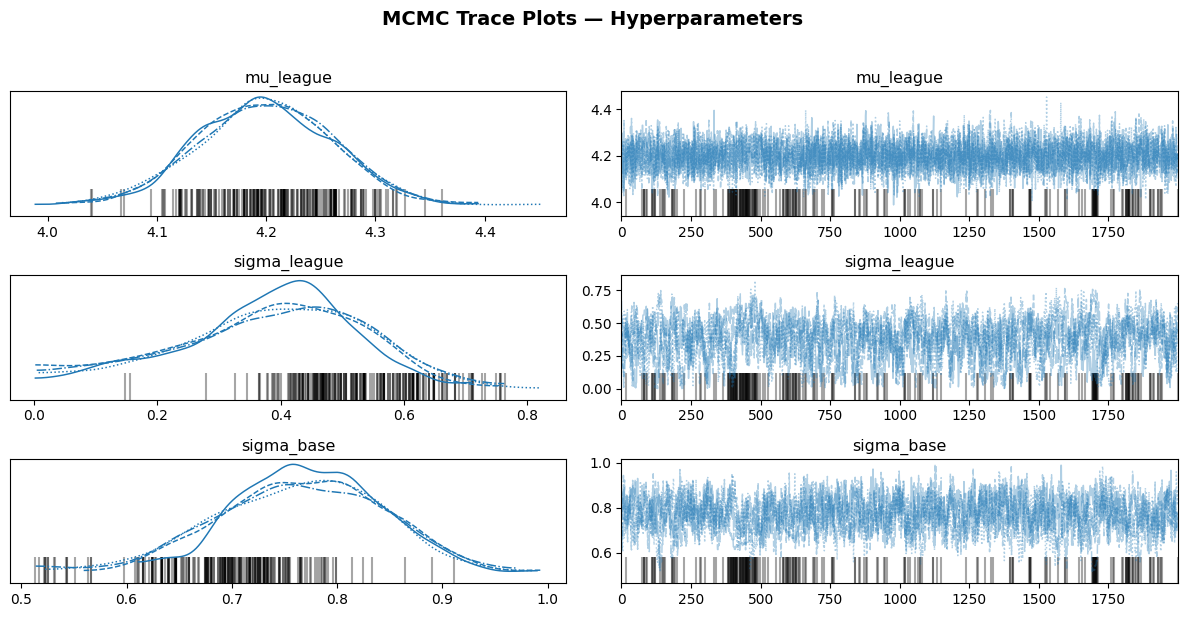

In [17]:
# Trace plots for hyperparameters
az.plot_trace(
    idata, 
    var_names=["mu_league", "sigma_league", "sigma_base"],
    figsize=(12, 6),
    compact=True
)
plt.suptitle("MCMC Trace Plots — Hyperparameters", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


## 6. Results — Posterior Skill Estimates


With inference complete, we extract the posterior samples for $\theta$ and summarize them into interpretable quantities.

`idata.posterior["theta"]` returns an array of shape `(chains, draws, pitchers)` — 
every sample the four chains drew for every pitcher's true skill. We flatten the chains 
and draw dimensions into a single axis, giving us 8000 posterior samples 
for each of the 230 pitchers.

From those 8000 samples per pitcher we compute four summary statistics:

- **`posterior_mean`** — the single best estimate of true skill, analogous to a 
point estimate but grounded in the full posterior
- **`posterior_std`** — how uncertain we are about that estimate; wide means few 
innings, narrow means lots of data
- **`ci_lower_90` / `ci_upper_90`** — the 90% credible interval, meaning there is 
a 90% probability the pitcher's true skill falls within this range given the data
- **`shrinkage`** — the raw FIP minus the posterior mean; positive values mean the 
model pulled the estimate down toward the league mean, negative means it was pulled up

We also compare the posterior league mean against the raw sample mean as a sanity 
check. They should be close but not identical.

In [18]:
# Extract posterior samples for theta (pitcher true skill)
theta_samples = idata.posterior["theta"].values  # shape: (chains, draws, pitchers)
theta_samples_flat = theta_samples.reshape(-1, N)  # (total_draws, pitchers)

# Posterior summaries
posterior_mean = theta_samples_flat.mean(axis=0)
posterior_std = theta_samples_flat.std(axis=0)
ci_lower = np.percentile(theta_samples_flat, 5, axis=0)
ci_upper = np.percentile(theta_samples_flat, 95, axis=0)

# Build results dataframe
results = fangraphs_2025_pitching[["name", "team", "ip", "fip", "era"]].copy()
results["posterior_mean"]  = posterior_mean
results["posterior_std"] = posterior_std
results["ci_lower_90"] = ci_lower
results["ci_upper_90"] = ci_upper
results["shrinkage"] = results["fip"] - results["posterior_mean"]  # positive = shrunk toward mean

league_mean_post = idata.posterior["mu_league"].values.mean()
print(f"Posterior league mean FIP: {league_mean_post:.3f}")
print(f"Real sample mean FIP: {fangraphs_2025_pitching['fip'].mean():.3f}")
print(f"\nTop 10 pitchers by posterior skill estimate (lowest true FIP):")
results.sort_values("posterior_mean").head(10)[
    ["name", "team", "ip", "fip", "posterior_mean", "posterior_std"]
].round(3)


Posterior league mean FIP: 4.199
Real sample mean FIP: 4.336

Top 10 pitchers by posterior skill estimate (lowest true FIP):


,name,team,ip,fip,posterior_mean,posterior_std
9,Paul Skenes,PIT,187.2,2.36,3.620,0.451
3,Tarik Skubal,DET,195.1,2.45,3.650,0.430
2,Cristopher Sánchez,PHI,202.0,2.55,3.661,0.428
0,Logan Webb,SFG,207.0,2.60,3.685,0.411
1,Garrett Crochet,BOS,205.1,2.89,3.770,0.376
14,Jesús Luzardo,PHI,183.2,2.90,3.805,0.381
99,Chris Sale,ATL,125.2,2.67,3.832,0.396
27,Yoshinobu Yamamoto,LAD,173.2,2.94,3.834,0.371
5,Max Fried,NYY,195.1,3.07,3.839,0.358
93,Nathan Eovaldi,TEX,130.0,2.80,3.857,0.387


In [19]:
print("Bottom 10 pitchers (highest true FIP — worst skill):")
results.sort_values("posterior_mean", ascending=False).head(10)[
    ["name", "team", "ip", "fip", "posterior_mean", "posterior_std"]
].round(3)


Bottom 10 pitchers (highest true FIP — worst skill):


,name,team,ip,fip,posterior_mean,posterior_std
20,Jake Irvin,WSN,180.0,5.64,4.630,0.414
291,Bradley Blalock,COL,58.2,7.31,4.618,0.476
115,Jack Kochanowicz,LAA,111.0,6.05,4.606,0.440
252,Bowden Francis,TOR,64.0,6.85,4.579,0.458
442,Nestor Cortes,2 Tms,34.1,8.29,4.566,0.474
98,Walker Buehler,2 Tms,126.0,5.66,4.548,0.410
84,Tyler Anderson,LAA,136.1,5.60,4.545,0.394
104,Andrew Heaney,2 Tms,122.1,5.59,4.521,0.396
444,Carson Palmquist,COL,34.1,7.80,4.520,0.452
58,Tomoyuki Sugano,BAL,157.0,5.36,4.512,0.379


## 7. The Shrinkage Plot

This is the central visualization of the model, it shows what the Bayesian inference 
actually did to each pitcher's raw FIP.

Each pitcher is represented by three elements:

- **Gray dot** — the raw observed FIP
- **Blue dot with error bars** — the posterior mean and 90% credible interval, the 
model's estimate of true skill with uncertainty
- **Arrow** — the shrinkage, connecting raw FIP to posterior estimate. The direction 
shows which way the model pulled the estimate, always toward the league mean. The 
length shows how much it moved.

The vertical dashed line is the posterior league mean. Pitchers on either extreme with few innings are the 
most interesting cases, where the gap between the raw FIP and the posterior estimate 
is largest and the interpretation of the raw number is most misleading.

Figure available in repository

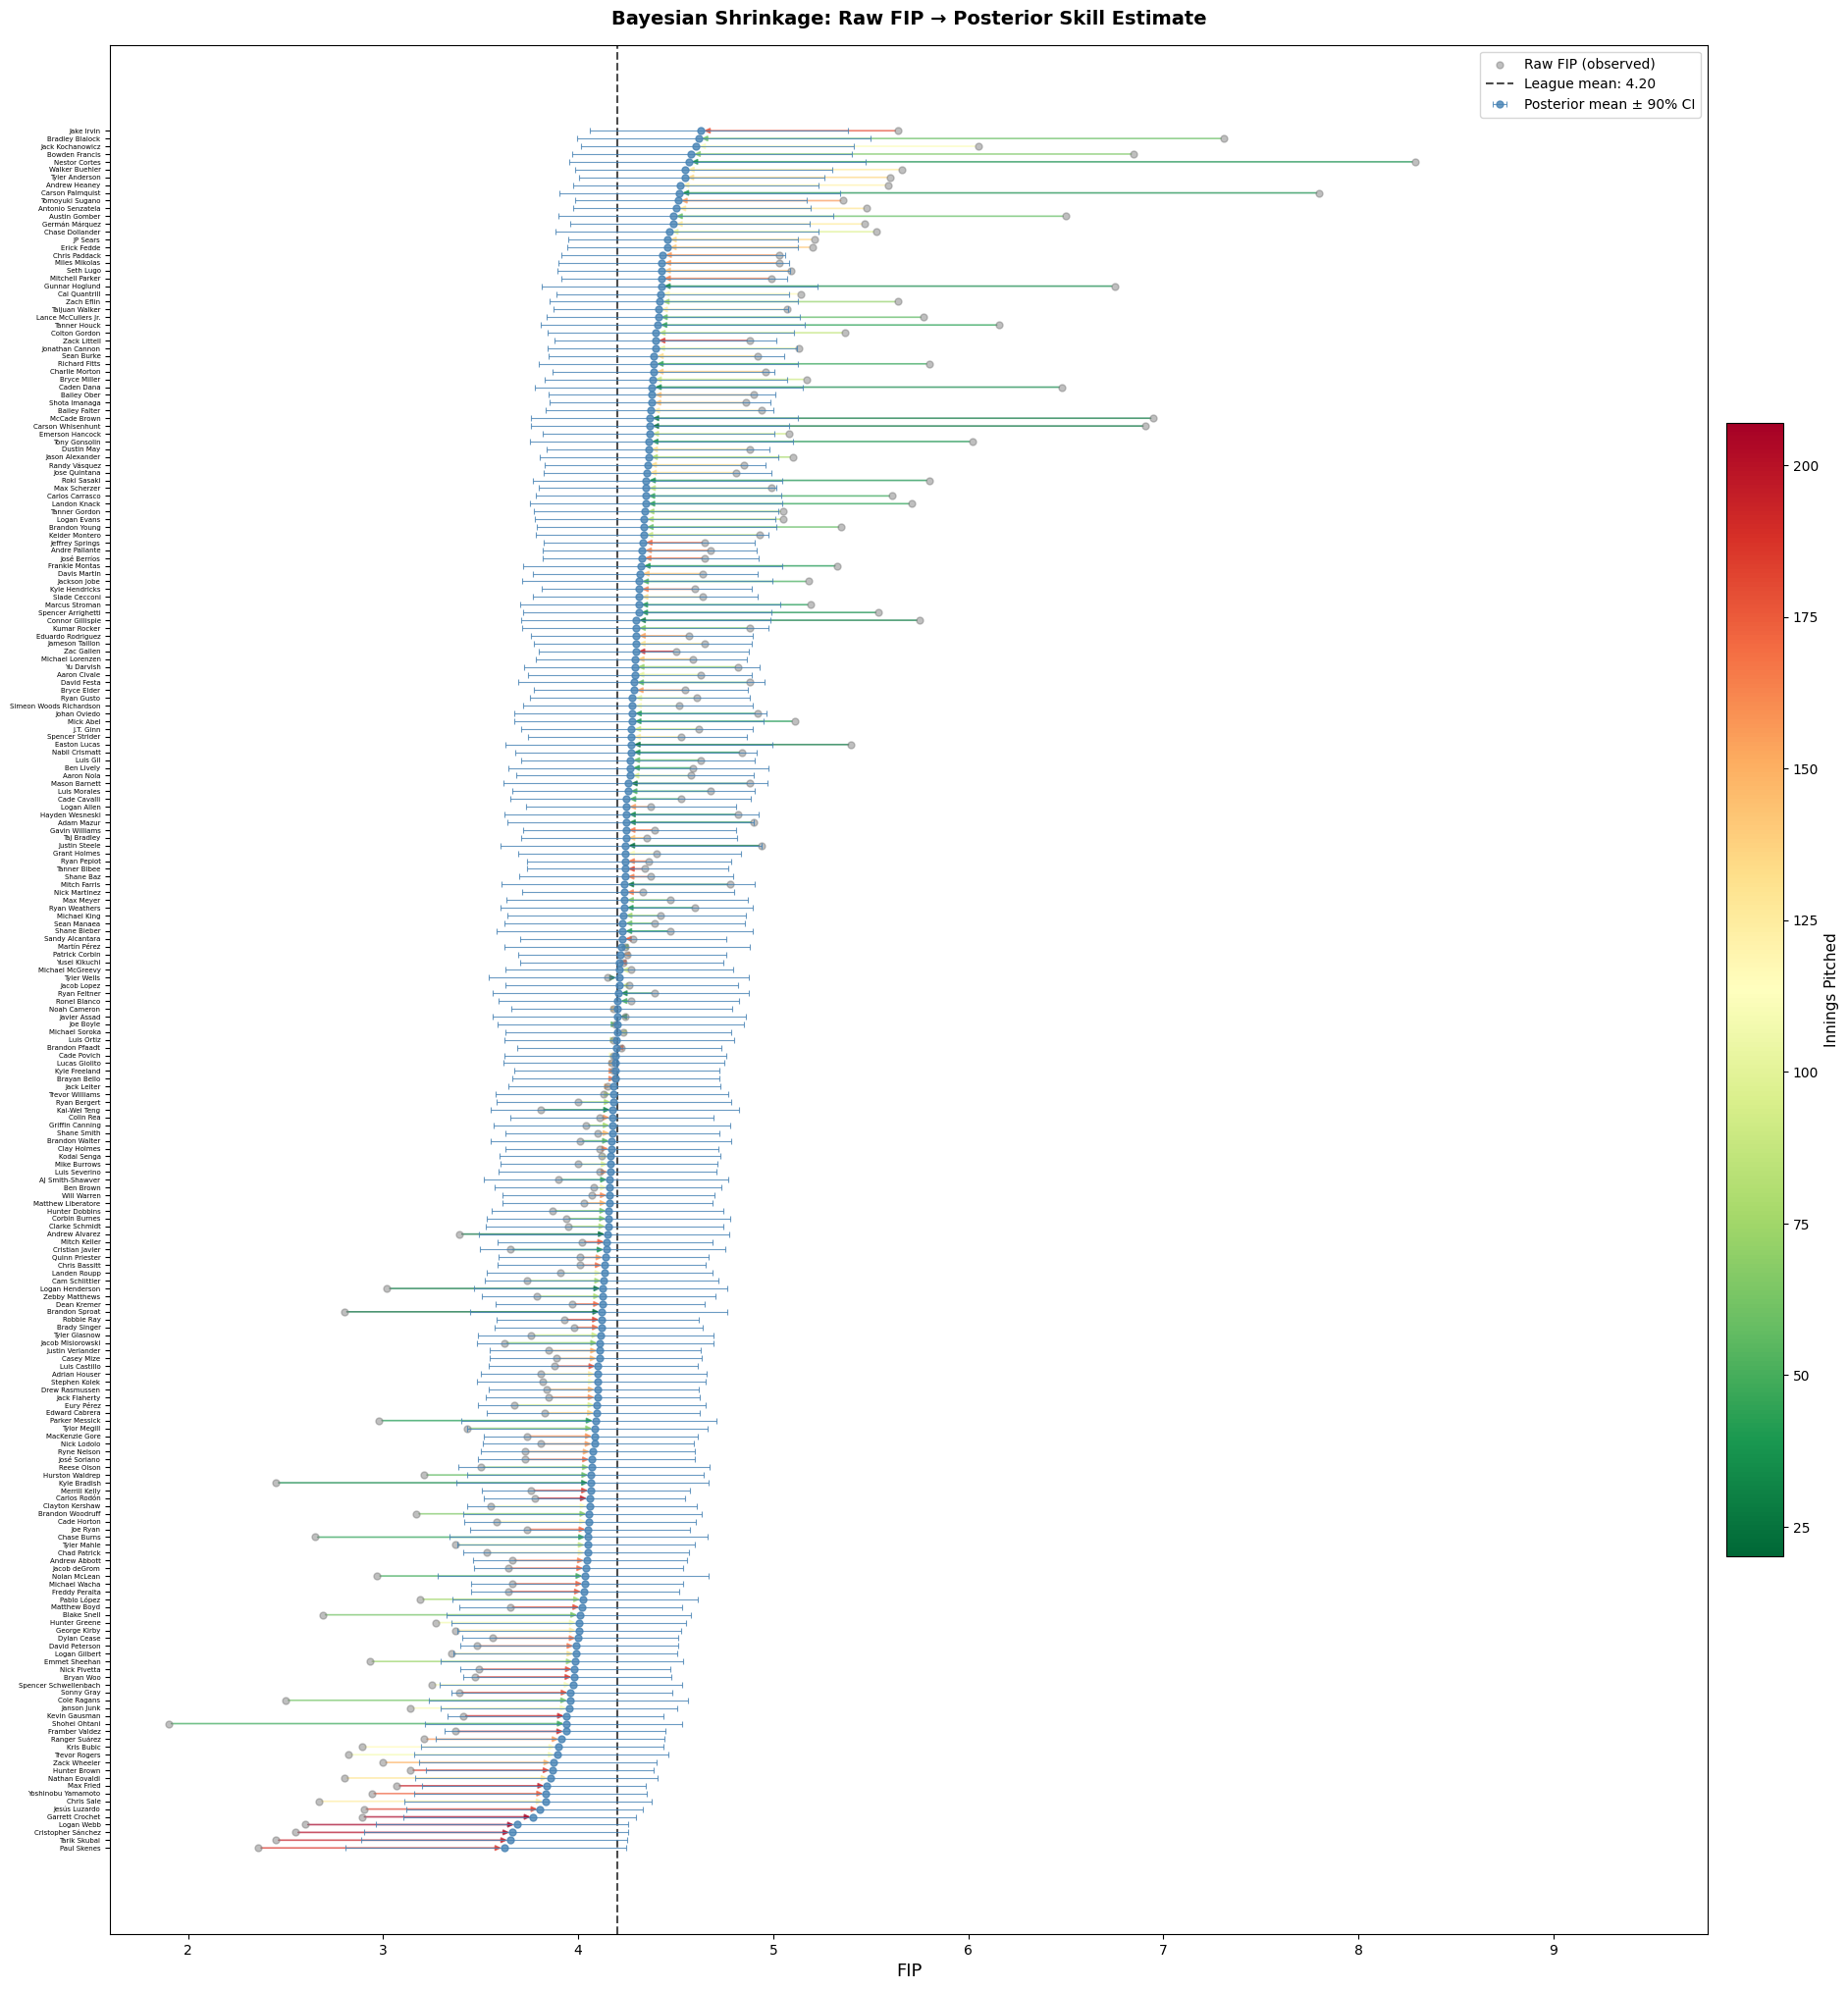

In [20]:
fig, ax = plt.subplots(figsize=(25, 25))

# Sort by posterior mean for a clean display
plot_fangraphs_2025_pitching = results.sort_values("posterior_mean").reset_index(drop=True)

# Normalize IP for color mapping
ip_norm = (plot_fangraphs_2025_pitching["ip"] - plot_fangraphs_2025_pitching["ip"].min()) / (plot_fangraphs_2025_pitching["ip"].max() - plot_fangraphs_2025_pitching["ip"].min())
colors = plt.cm.RdYlGn_r(ip_norm)  # red = few IP, green = many IP

y_positions = np.arange(len(plot_fangraphs_2025_pitching))

# Draw shrinkage arrows
for i, row in plot_fangraphs_2025_pitching.iterrows():
    ax.annotate(
        "", 
        xy=(row["posterior_mean"], i),
        xytext=(row["fip"], i),
        arrowprops=dict(arrowstyle="-|>", color=colors[i], lw=1.2, 
                        mutation_scale=8, alpha=0.7)
    )

# Plot raw FIP
ax.scatter(plot_fangraphs_2025_pitching["fip"], y_positions, 
           color="gray", alpha=0.5, s=25, zorder=3, label="Raw FIP (observed)")

# Plot posterior means with uncertainty
ax.errorbar(
    plot_fangraphs_2025_pitching["posterior_mean"], y_positions,
    xerr=[plot_fangraphs_2025_pitching["posterior_mean"] - plot_fangraphs_2025_pitching["ci_lower_90"],
          plot_fangraphs_2025_pitching["ci_upper_90"] - plot_fangraphs_2025_pitching["posterior_mean"]],
    fmt="o", color="steelblue", markersize=5, alpha=0.8,
    elinewidth=0.8, capsize=2, capthick=0.8, label="Posterior mean ± 90% CI", zorder=4
)

# League mean line
ax.axvline(league_mean_post, color="black", linestyle="--", lw=1.5, 
           alpha=0.7, label=f"League mean: {league_mean_post:.2f}")


# Colorbar for IP
sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", 
                            norm=plt.Normalize(plot_fangraphs_2025_pitching["ip"].min(), plot_fangraphs_2025_pitching["ip"].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, shrink=0.6)
cbar.set_label("Innings Pitched", fontsize=11)

ax.set_yticks(y_positions)
ax.set_yticklabels(plot_fangraphs_2025_pitching["name"], fontsize=5)
ax.set_xlabel("FIP", fontsize=13)
ax.set_title("Bayesian Shrinkage: Raw FIP → Posterior Skill Estimate",
             fontsize=14, fontweight="bold", pad=15)
ax.legend(loc="upper right", fontsize=10)
ax.set_xlim(plot_fangraphs_2025_pitching[["fip", "ci_lower_90"]].min().min() - 0.3,
            plot_fangraphs_2025_pitching[["fip", "ci_upper_90"]].max().max() + 1.5)
plt.savefig("Bayesian_Shrinkage_Figure.jpg")

plt.show()


## 8. Case Studies — Luck vs. Skill

Let's zoom in on specific pitchers to illustrate the model's reasoning.

**Cases to examine:**
1. A pitcher with elite raw FIP but low innings — the model is skeptical
2. A workhorse with a mediocre raw FIP but high confidence
3. A pitcher whose ERA and FIP tell very different stories


Shohei Ohtani — LAD | 47 IP | Raw FIP 1.90 → Posterior mean 3.94
The most dramatic shrinkage in the chart. Ohtani's raw FIP of 1.90 would make him look like the best pitcher in baseball, but with only 47 innings the model is deeply skeptical. The posterior mean of 3.94 sits almost exactly at the league average. The wide distribution confirms the uncertainty. This is also complicated by the fact that Ohtani is transitioning back to pitching after a full season off, which the model can't know but the shrinkage inadvertently captures. 

Nestor Cortes — 2 Tms | 34 IP | Raw FIP 8.29 → Posterior mean 4.57
The mirror image. A raw FIP of 8.29 would suggest one of the worst starters in baseball, but with only 34 innings the model pulls him back to 4.57, above average but far from catastrophic.

Connor Gillispie — MIA | 26 IP | Raw FIP 5.75 → Posterior mean 4.30
The subtlest case. A raw FIP of 5.75 looks concerning but the ERA of 8.65 is alarming, yet the model puts his true skill near league average at 4.30. With only 26 IP and an ERA that far above his FIP, the model detects that a lot of what's happened is likely defense and bad luck rather than true skill. The narrow posterior relative to the other two reflects that 5.75 isn't extreme enough to resist the prior as strongly as 1.90 or 8.29.


Case 1 - Most 'lucky' (ERA much lower than FIP): Nestor Cortes
Case 2 - Most 'unlucky' (ERA much higher than FIP): Connor Gillispie
Case 3 - Small-sample FIP ace (<50 IP): Shohei Ohtani


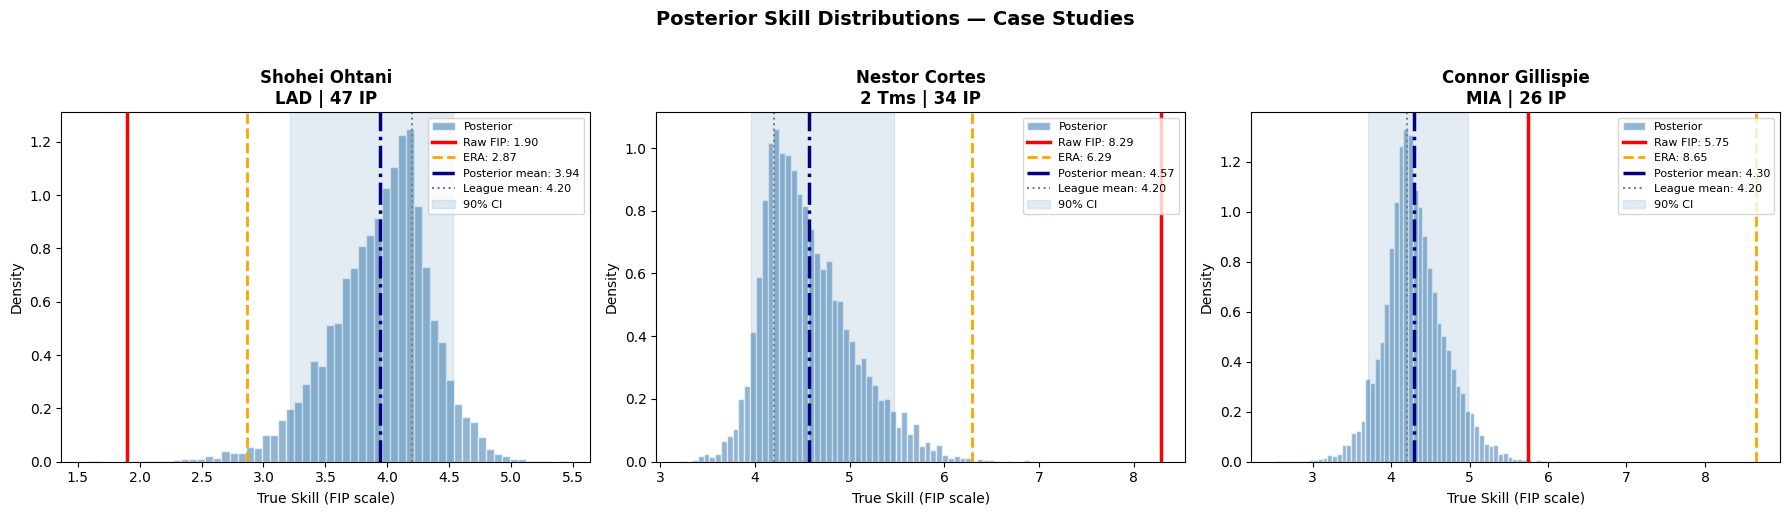

In [21]:
def plot_pitcher_posterior(names, ax_grid=None):
    pitchers_data = results[results["name"].isin(names)].reset_index(drop=True)
    
    n = len(pitchers_data)
    if ax_grid is None:
        fig, axes = plt.subplots(1, n, figsize=(5*n, 5), sharey=False)
        if n == 1: axes = [axes]
    else:
        axes = ax_grid
    
    for ax, (_, row) in zip(axes, pitchers_data.iterrows()):
        # Use positional location, not DataFrame index
        idx = results.reset_index(drop=True)[results.reset_index(drop=True)["name"] == row["name"]].index[0]
        samples = theta_samples_flat[:, idx]
        
        ax.hist(samples, bins=60, density=True, color="steelblue", 
                alpha=0.6, edgecolor="white", label="Posterior")
        ax.axvline(row["fip"], color="red", lw=2.5, linestyle="-",
                   label=f"Raw FIP: {row['fip']:.2f}")
        ax.axvline(row["era"], color="orange", lw=2, linestyle="--",
                   label=f"ERA: {row['era']:.2f}")
        ax.axvline(row["posterior_mean"], color="navy", lw=2.5, linestyle="-.",
                   label=f"Posterior mean: {row['posterior_mean']:.2f}")
        ax.axvline(league_mean_post, color="gray", lw=1.5, linestyle=":",
                   label=f"League mean: {league_mean_post:.2f}")
        ax.axvspan(row["ci_lower_90"], row["ci_upper_90"], 
                   alpha=0.15, color="steelblue", label="90% CI")
        ax.set_title(f"{row['name']}\n{row['team']} | {row['ip']:.0f} IP", 
                     fontsize=12, fontweight="bold")
        ax.set_xlabel("True Skill (FIP scale)", fontsize=10)
        ax.set_ylabel("Density", fontsize=10)
        ax.legend(fontsize=8, loc="upper right")
    
    return axes

# Find interesting cases
# 1. Most extreme positive luck (ERA much better than FIP)
lucky = results.assign(luck=results["era"] - results["fip"]).sort_values("luck")
overperformer = lucky.iloc[0]["name"]   # ERA << FIP (got lucky)
underperformer = lucky.iloc[-1]["name"] # ERA >> FIP (got unlucky)

# 2. Low IP but great FIP  
small_sample_ace = results[results["ip"] < 50].sort_values("fip").iloc[0]["name"]

print(f"Case 1 - Most 'lucky' (ERA much lower than FIP): {overperformer}")
print(f"Case 2 - Most 'unlucky' (ERA much higher than FIP): {underperformer}")
print(f"Case 3 - Small-sample FIP ace (<50 IP): {small_sample_ace}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_pitcher_posterior([overperformer, underperformer, small_sample_ace], ax_grid=axes)
plt.suptitle("Posterior Skill Distributions — Case Studies", 
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


## 9. Posterior Predictive Check

A good Bayesian model should be able to reproduce the observed data. We sample from the posterior predictive distribution and check that it matches the shape of actual FIPs.


**Left — distribution overlap**

The blue draws represent what the model thinks FIP distributions should look like across 
many simulated seasons. The red line is the actual observed distribution. The bulk of 
the model predictions align well with reality, but the model does produce some physically impossible values (negative FIP, 
FIP above 10) because it assumes a normal distribution with no hard boundaries. This is 
a known limitation of the normality assumption.

**Right — observed vs. predicted**

This plot exposes the shrinkage directly. A perfect predictive model would have all 
points along the red diagonal, instead we see a horizontal 
band where extreme observed FIPs are all pulled back toward 4.0–4.5 in the predictions. 
A pitcher observed at 8.5 FIP gets predicted at roughly 4.5. This looks like a poor fit 
but is actually the intended behavior, with the model correctly distrusting extreme values from 
small samples and estimates true skill closer to the league mean.


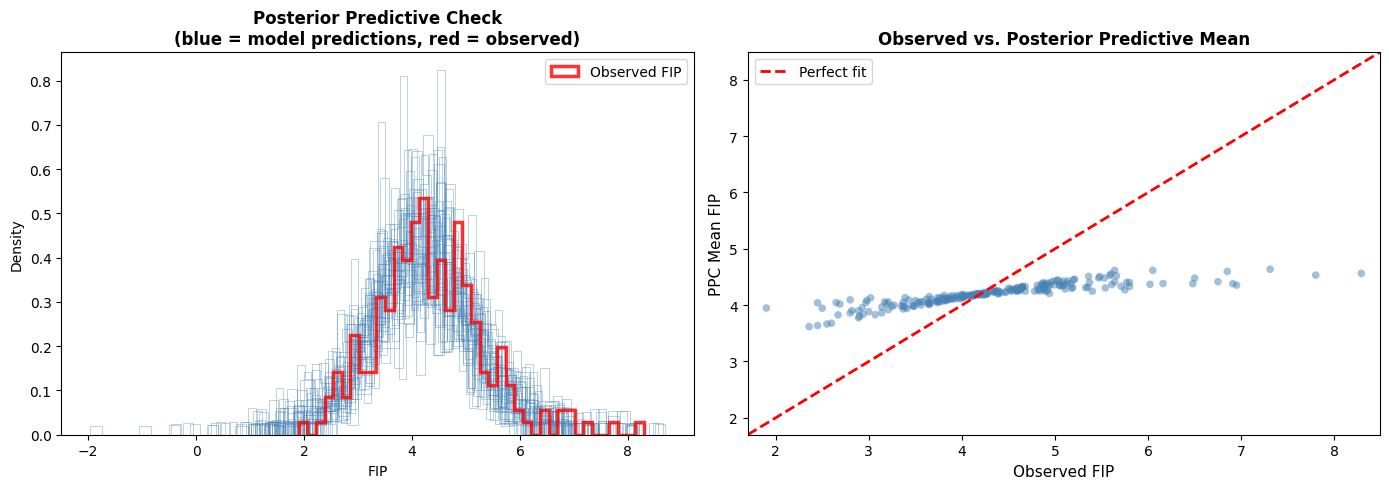

In [22]:
# Generate posterior predictive samples
predictive = Predictive(pitcher_model, posterior_samples=mcmc.get_samples())
rng_key_pred = random.PRNGKey(42)
ppc_samples = predictive(rng_key_pred, None, ip_arr, N)

fip_ppc = ppc_samples["fip"]  # shape: (draws, n_pitchers)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: overlay PPC draws vs observed
ax = axes[0]
for i in range(0, min(200, fip_ppc.shape[0]), 5):
    ax.hist(fip_ppc[i], bins=40, density=True, alpha=0.5, color="steelblue", 
            histtype="step", linewidth=0.5)
ax.hist(fangraphs_2025_pitching["fip"], bins=40, density=True, alpha=0.8, color="red", 
        histtype="step", linewidth=2.5, label="Observed FIP")
ax.set_title("Posterior Predictive Check\n(blue = model predictions, red = observed)", 
             fontsize=12, fontweight="bold")
ax.set_xlabel("FIP"); ax.set_ylabel("Density")
ax.legend()

# Right: mean PPC vs observed
ax = axes[1]
ppc_mean = fip_ppc.mean(axis=0)
ax.scatter(fangraphs_2025_pitching["fip"], ppc_mean, alpha=0.5, s=30, color="steelblue", edgecolors="none")
lims = [min(fangraphs_2025_pitching["fip"].min(), ppc_mean.min()) - 0.2, 
        max(fangraphs_2025_pitching["fip"].max(), ppc_mean.max()) + 0.2]
ax.plot(lims, lims, "r--", lw=2, label="Perfect fit")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Observed FIP", fontsize=11)
ax.set_ylabel("PPC Mean FIP", fontsize=11)
ax.set_title("Observed vs. Posterior Predictive Mean", fontsize=12, fontweight="bold")
ax.legend()

plt.tight_layout()
plt.show()


## 10. Uncertainty-Aware Rankings

Traditional rankings sort by raw FIP. Our Bayesian model gives us something better lets us examine what the probability is that pitcher A is truly better than pitcher B.

Paul Skenes, Tarik Skubal, Cristopher Sánchez, Logan Webb, and Garrett Crochet all have high innings pitched and tight credible 
intervals. Their raw FIP markers sit close to their posterior means, meaning the model 
barely adjusted their numbers, indicating that the data was strong enough to speak for itself.

Paul Skenes stands alone at #1. With 187 IP and a posterior mean well below every 
other pitcher in the top 20, the model is more confident in his elite status than anyone 
else on this list. The gap between him and #2 Skubal is meaningful and supported by the 
data.

Shohei Ohtani at #17 is the most important caveat in the chart. With only 47 IP his 
credible interval spans nearly the entire x-axis, the model cannot distinguish whether 
he is a top-5 pitcher or an average one. His presence in the top 20 reflects an 
impressive raw FIP, and with everything we know about him we can likely believe it to be true, but the model is wary.

Cole Ragans at #20 tells a similar story. The widest bar in the chart and only 61 IP. 
His raw FIP sits noticeably to the left of his posterior mean, meaning the model pulled 
his estimate back toward the league average significantly. His ranking is the most 
provisional on the list.


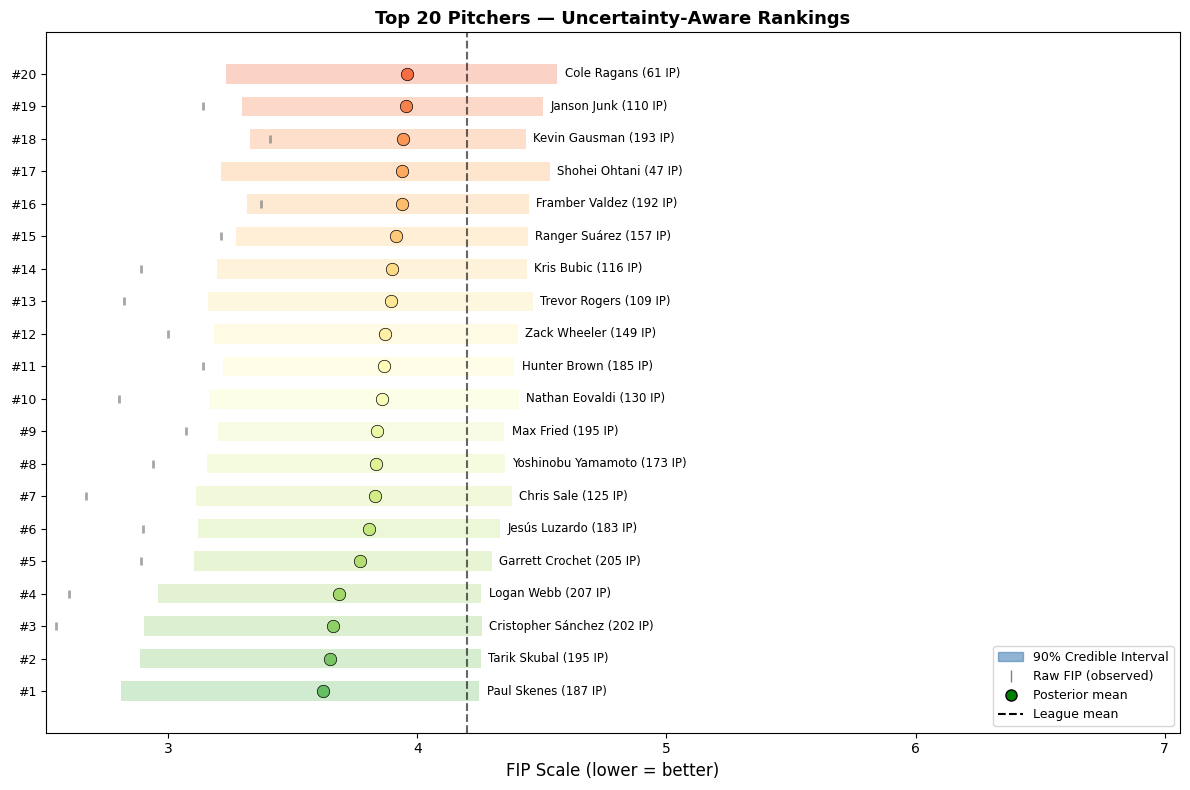

In [23]:
# Rank by posterior mean, show top 20 with uncertainty bands
top20 = results.sort_values("posterior_mean").head(20).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 8))

colors_rank = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(top20)))

for i, row in top20.iterrows():
    # Background bar = 90% CI width
    ax.barh(i, row["ci_upper_90"] - row["ci_lower_90"], 
            left=row["ci_lower_90"], height=0.6, 
            color=colors_rank[i], alpha=0.3)
    # Point estimate
    ax.scatter(row["posterior_mean"], i, color=colors_rank[i], 
               s=80, zorder=5, edgecolors="black", linewidth=0.5)
    # Raw FIP marker
    ax.scatter(row["fip"], i, color="gray", s=30, zorder=4, 
               marker="|", linewidth=2, alpha=0.7)
    # Label
    ax.text(row["ci_upper_90"] + 0.03, i, 
            f"{row['name']} ({row['ip']:.0f} IP)", 
            va="center", fontsize=8.5)

ax.axvline(league_mean_post, color="black", linestyle="--", lw=1.5, alpha=0.6,
           label=f"League mean FIP")

# Legend
dot = mpatches.Patch(color="steelblue", alpha=0.6, label="90% Credible Interval")
ax.scatter([], [], color="gray", marker="|", s=50, label="Raw FIP (observed)", linewidths=2)
ax.scatter([], [], color="green", s=80, edgecolors="black", lw=0.5, label="Posterior mean")
ax.legend(handles=[dot, 
                    plt.Line2D([0],[0], marker="|", color="gray", markersize=8, 
                               linewidth=0, label="Raw FIP (observed)"),
                    plt.Line2D([0],[0], marker="o", color="green", markersize=8,
                               markeredgecolor="black", linewidth=0, label="Posterior mean"),
                    plt.Line2D([0],[0], color="black", linestyle="--", label="League mean")],
          loc="lower right", fontsize=9)

ax.set_yticks(range(len(top20)))
ax.set_yticklabels([f"#{i+1}" for i in range(len(top20))], fontsize=9)
ax.set_xlabel("FIP Scale (lower = better)", fontsize=12)
ax.set_title("Top 20 Pitchers — Uncertainty-Aware Rankings", 
             fontsize=13, fontweight="bold")
ax.set_xlim(top20["ci_lower_90"].min() - 0.3, 
            top20["ci_upper_90"].max() + 2.5)

plt.tight_layout()
plt.show()


## 11. Pairwise "Who's Actually Better?" Probabilities

For any two pitchers, we can compute the exact probability that one has a lower true FIP than the other.


Given the full posterior distributions of two pitchers, what is the probability that one is genuinely more 
skilled than the other? Each cell shows P(row pitcher has lower true FIP than column 
pitcher). Green means the row pitcher is likely better, red means the column pitcher 
is likely better.

The Skenes-Skubal debate is essentially a coin flip. A probability of 0.52 means 
the model cannot meaningfully separate them. Their posterior distributions overlap 
almost entirely. Despite Skenes ranking #1 and Skubal #2, calling either one definitively 
better than the other is not supported by the data.

The top 6 vs. bottom 4 split is the most striking pattern. Skenes, Skubal, Sanchez, 
Webb, Crochet, and Luzardo are all highly likely to be better than Sale, Yamamoto, Fried, 
and Eovaldi, probabilities in the 0.80-0.92 range.

The yellow cells along the top-left block show where uncertainty lives. Skenes vs. 
Webb at 0.55, Sanchez vs. Skubal at 0.50. There is a strong case for Christopher Sanchez being the most underrated pitcher in the sport.

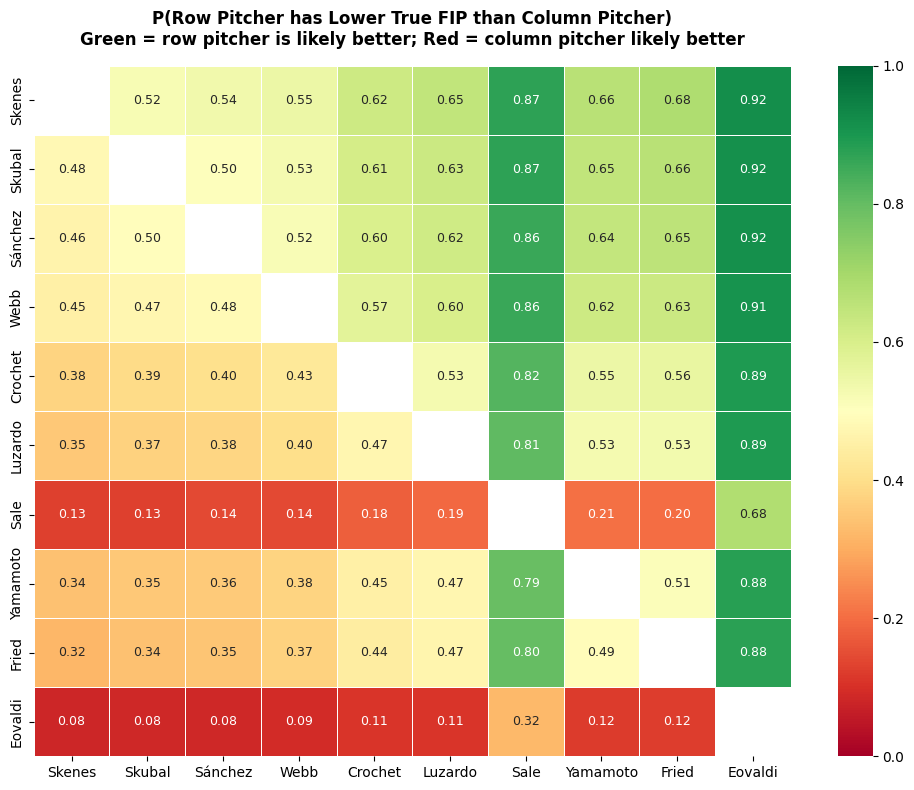

In [24]:
def prob_better(name_a, name_b, results_fangraphs_2025_pitching, samples):
    """P(pitcher A has lower true FIP than pitcher B)"""
    idx_a = results_fangraphs_2025_pitching[results_fangraphs_2025_pitching["name"] == name_a].index[0]
    idx_b = results_fangraphs_2025_pitching[results_fangraphs_2025_pitching["name"] == name_b].index[0]
    prob = (samples[:, idx_a] < samples[:, idx_b]).mean()
    return float(prob)

# Compare top 10 pitchers pairwise
top10_names = results.sort_values("posterior_mean").head(10)["name"].tolist()
n = len(top10_names)
prob_matrix = np.zeros((n, n))

for i, a in enumerate(top10_names):
    for j, b in enumerate(top10_names):
        if i != j:
            prob_matrix[i, j] = prob_better(a, b, results, theta_samples_flat)
        else:
            prob_matrix[i, j] = 0.5

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.eye(n, dtype=bool)
sns.heatmap(
    prob_matrix, 
    xticklabels=[n.split()[-1] for n in top10_names],
    yticklabels=[n.split()[-1] for n in top10_names],
    annot=True, fmt=".2f", cmap="RdYlGn", 
    vmin=0, vmax=1, ax=ax,
    linewidths=0.5, linecolor="white",
    mask=mask,
    annot_kws={"size": 9}
)

ax.set_title("P(Row Pitcher has Lower True FIP than Column Pitcher)\n"
             "Green = row pitcher is likely better; Red = column pitcher likely better",
             fontsize=12, fontweight="bold", pad=15)
ax.set_xlabel(""); ax.set_ylabel("")

plt.tight_layout()
plt.show()


## Limitations, Key Takeaways & Extensions

### Limitations

**Single season, no temporal structure.**
The model treats each pitcher's FIP as a static snapshot. A pitcher who started the season well and faded, or vice versa, gets averaged 
into a single estimate that obscures the trajectory entirely. True skill almost 
certainly changes within a season, and the model has no mechanism to capture that.

**Normality assumption.**
We assume observed FIP is normally distributed around true skill. In reality FIP 
distributions are slightly right-skewed with a small number of pitchers having catastrophic 
stretches that pull the tail out. A skew-normal or Student-t likelihood would likely be more 
robust to these outliers, particularly for low-IP pitchers whose extreme values have 
outsized influence. I chose a normal distribution for the sake of simplicity.

**FIP is not true skill.**
FIP itself is already a model, it removes defense but still contains luck in the form 
of home run variance and sequencing effects. We are estimating a pitcher's true 
underlying FIP, not their true underlying ability. xFIP or SIERA would be a more 
theoretically defensible target variable since they regress home run rates to league 
average, removing another layer of noise, however the argument surrounding the best indicator of pitching success is endless and largely futile.

**No pitcher-level covariates.**
Every pitcher enters the model with the same prior regardless of age, track record, 
stuff metrics, or injury history. This is the most significant limitation. The model strongly penalizes Shohei Ohtani, but we know that he has been elite.

**Independence assumption.**
The model assumes each pitcher's true skill is independent of every other pitcher's. 
In reality there may be team-level effects, such as pitching coaches, defensive systems, and 
ballpark factors that create correlations between teammates that the model ignores.

---

### Key Takeaways

**Most top-10 comparisons are statistically meaningless.**
The pairwise probability matrix showed that separating pitchers within the elite 
tier is essentially a coin flip. Confident claims about who the second or third best pitcher in 
baseball is are not supported by the data at this sample size.

**IP is the most important number on the leaderboard.**
Not ERA, not FIP, not K/9. Innings pitched determines how much any statistic should 
be trusted. The model formalizes this intuition into a principled shrinkage mechanism, 
but the underlying insight is simple: sample size is everything in a 162-game season 
evaluated at the midpoint.

**Most importantly.**
This was my first time building a Bayesian model from scratch. I learned JAX, NumPyro, and hierarchical modeling through building this project, and 
it shows in places, such as the convergence issues with sigma_league that required a 
non-centered reparameterization, the truncated normal experiment that I breifly experimented with that made things 
worse, and the general limitations of the work. I revealed nothing groundbreaking here, and I am very aware of that, it was more of an experiment with the libraries and baseball data.

---

### Extensions

**Pitcher-level priors using historical data**
The most significant limitation of this model is that every pitcher shares the same 
league-wide prior. A natural and powerful improvement would be to construct 
individual priors for each pitcher using their historical FIP. For a veteran like 
Max Fried with seven seasons of data, his prior would be tight and centered on his 
career FIP. The model would trust his history and require substantial evidence to 
move away from it. For a rookie with no MLB track record, the prior would fall back 
to the league mean with high uncertainty, exactly as the current model behaves. 
Practically this would mean replacing:

$$\theta_i \sim \mathcal{N}(\mu_{\text{league}},\ \sigma_{\text{league}})$$

with:

$$\theta_i \sim \mathcal{N}(\mu_{\text{career},i},\ \sigma_{\text{career},i})$$

where $\mu_{\text{career},i}$ and $\sigma_{\text{career},i}$ are derived from each 
pitcher's historical performance, with $\sigma_{\text{career},i}$ shrinking as more 
seasons of data accumulate. This would make the model significantly more informative 
for established pitchers while preserving appropriate uncertainty for newcomers.